In [1]:
import pandas as pd

In [2]:
#importiamo housing database e assegnamo i nomi alle colonne (feature)
df=pd.read_csv('https://raw.githubusercontent.com/rasbt/'
          'python-machine-learning-book-2nd-edition'
          '/master/code/ch10/housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
             'NOX', 'RM', 'AGE', 'DIS', 'RAD',
             'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
#creiamo la scatterplot matrix per le correlazioni tra feature
import matplotlib.pyplot as plt
import seaborn as sns

/home/ivan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


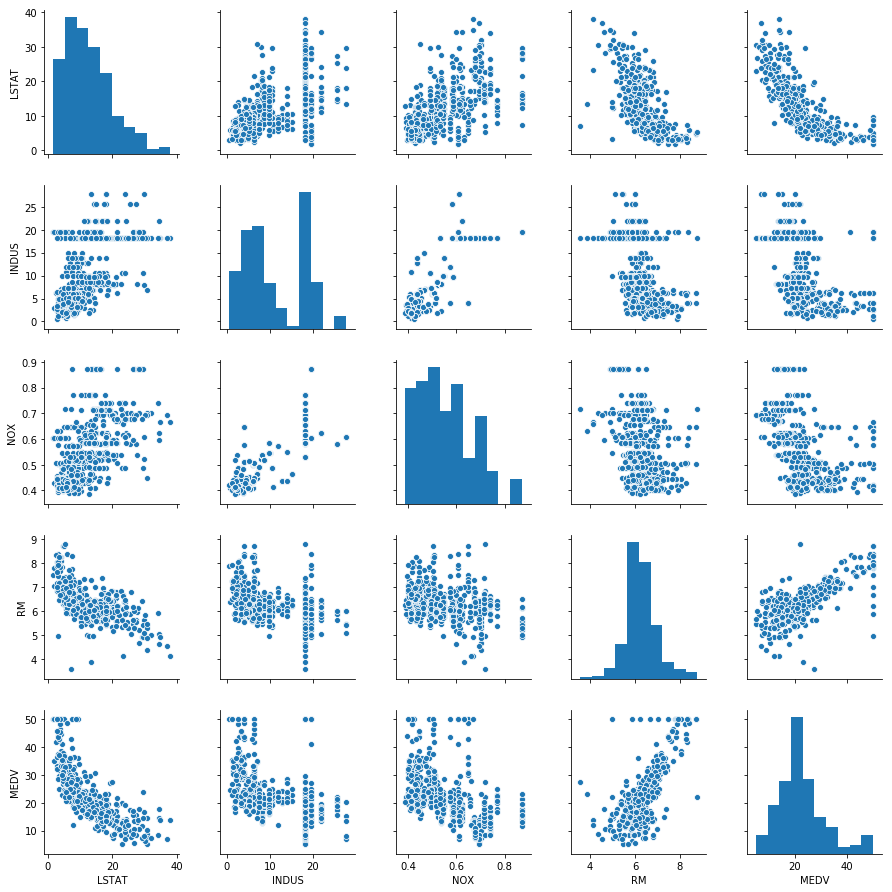

In [8]:
#selezioniamo solo 4 feature
cols=['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

In [9]:
#RM (average number of room per dwelling) e MEDV (MEdian value of owner-occupied homes in 1000$) 
#sembrano linearmente correlate 

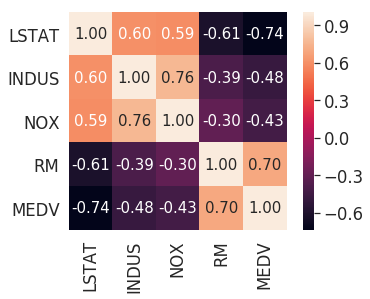

In [12]:
#calcoliamo Perason's r
import numpy as np
cm=np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm=sns.heatmap(cm,
              cbar=True,
              annot=True,
              square=True,
              fmt='.2f',
              annot_kws={'size': 15},
              yticklabels=cols,
              xticklabels=cols)
plt.show()

In [13]:
#RM e MEDV sono fortemente correlate positivamente (0.7)

In [15]:
#Regressione lineare
from sklearn.linear_model import LinearRegression
X=df[['RM']].values
y=df['MEDV'].values
slr=LinearRegression()
slr.fit(X, y)
print('Pendenza: %.3f' % slr.coef_[0])

Pendenza: 9.102


In [18]:
print('Intercetta: %.3f' %slr.intercept_)

Intercetta: -34.671


In [19]:
#Mostra come la regressione lineare fitta i training data
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

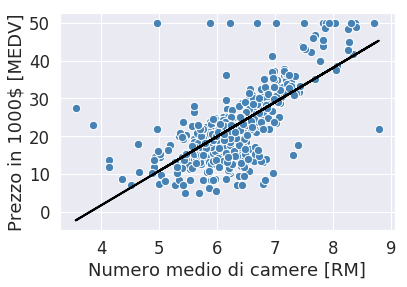

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Numero medio di camere [RM]')
plt.ylabel('Prezzo in 1000$ [MEDV]')
plt.show()

In [22]:
#RANSAC per ridurre l'effetto degli outliers
from sklearn.linear_model import RANSACRegressor
ransac=RANSACRegressor(LinearRegression(),
                      max_trials=100, #massimo numero di iterazioni
                      min_samples=50, #minimo numero di campioni scelti casualmente
                      loss='absolute_loss', #distanza verticale assoluta tra linea fittata e campioni
                      residual_threshold=5.0, #i campioni sono considersti inlier solo se la loro distanza con la linea fittata è <= 5 unità
                      random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

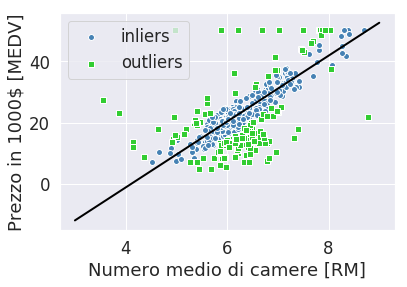

In [24]:
inlier_mask=ransac.inlier_mask_
outlier_mask=np.logical_not(inlier_mask)
line_X=np.arange(3, 10, 1)
line_y_ransac=ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
           c='steelblue', edgecolor='white',
           marker='o', label='inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c='limegreen', edgecolor='white',
           marker='s', label='outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Numero medio di camere [RM]')
plt.ylabel('Prezzo in 1000$ [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [26]:
print('Pendenza: %.3f' % ransac.estimator_.coef_[0])

Pendenza: 10.735


In [28]:
print('Intercetta: %.3f' % ransac.estimator_.intercept_)

Intercetta: -44.089


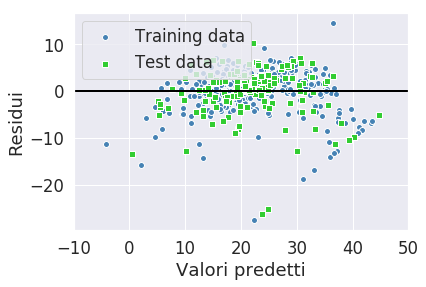

In [30]:
#dividiamo il dataset in train e test per valutare la performance
from sklearn.model_selection import train_test_split
X=df.iloc[:, :-1].values
y=df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.3, random_state=0)
slr=LinearRegression()
slr.fit(X_train, y_train)
y_train_pred=slr.predict(X_train)
y_test_pred=slr.predict(X_test)
#Plottiamo i residui (dovrebbero essere distribuiti casualmente intorno alla linea, no pattern)
plt.scatter(y_train_pred, y_train_pred - y_train,
           c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='limegreen', marker='s', edgecolor='white', label='Test data')
plt.xlabel('Valori predetti')
plt.ylabel('Residui')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
print ('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), 
                                        mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [33]:
from sklearn.metrics import r2_score
print ('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


In [34]:
#Regolarizzazione tramite Elastic Net
from sklearn.linear_model import ElasticNet
elanet= ElasticNet(alpha=1.0, l1_ratio=0.5)

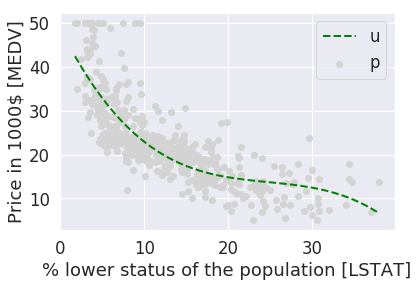

In [47]:
#Modelliamo ora una relazione non lineare come quella tra LSTAT e MEDV
from sklearn.preprocessing import PolynomialFeatures
X=df[['LSTAT']].values
y=df['MEDV'].values
regr=LinearRegression()
cubic=PolynomialFeatures(degree=3)
X_cubic=cubic.fit_transform(X)
X_fit=np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr=regr.fit(X_cubic, y)
y_cubic_fit=regr.predict(cubic.fit_transform(X_fit))
cubic_r2=r2_score(y, regr.predict(X_cubic))
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_cubic_fit,
        label='cubic (d=3), $R^2=.2f$' % cubic_r2, 
         color='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in 1000$ [MEDV]')
plt.legend('upper left')
plt.show()

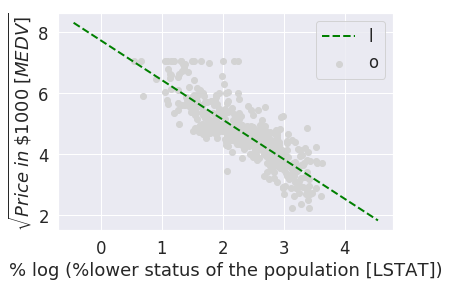

In [48]:
#Notando la relazione logaritmica tra MEDV e LSTAT si può usare la linear regression invece che la polinomiale
X_log=np.log(X)
y_sqrt=np.sqrt(y)
X_fit=np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr=regr.fit(X_log, y_sqrt)
y_lin_fit=regr.predict(X_fit)
linear_r2=r2_score(y_sqrt, regr.predict(X_log))
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit,
        label='linear (d=1), $R^2=.2f$' % linear_r2, 
         color='green', lw=2, linestyle='--')
plt.xlabel('% log (%lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000 \; [MEDV]}$')
plt.legend('lower left')
plt.show()

In [53]:
#Regressione random forest
X=df.iloc[:, :-1].values
y=df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.4,
                                                   random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=100,
                            criterion='mse',
                            random_state=1,
                            n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                      mean_squared_error(y_test, y_test_pred)))

MSE train: 1.675, test: 11.717


In [54]:
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

R^2 train: 0.979, test: 0.870


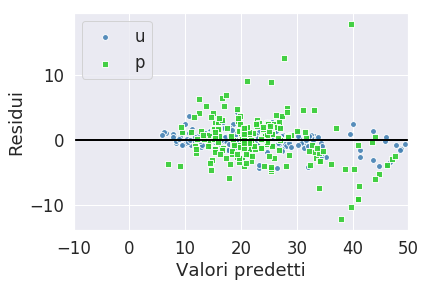

In [55]:
#R^2 train > test significa che il modello overfitta
plt.scatter(y_train_pred, y_train_pred-y_train,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred, y_test_pred-y_test,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35,
            alpha=0.9,
            label='test data')
plt.xlabel('Valori predetti')
plt.ylabel('Residui')
plt.legend('upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.show()

In [ ]:
#La distribuzione dei residui non deve seguire nessun pattern, ma la casualità del modoe reale.